# REM/CREM-style analytic phase diagram for $x_c(H,\beta)$

This notebook implements a **simplified correlated Random Energy Model (REM/CREM)**
consistent with the 1-RSB picture used in the paper:

- Energies are modeled as a correlated random energy landscape whose covariance
  spectrum depends on the Hurst exponent $H$ via $\rho_C(\lambda;H)$.
- The spectral second moment defines an effective coupling $J_{\mathrm{eff}}(H)$.
- In the REM/CREM limit, the 1-RSB breakpoint parameter is
  $$
     x_c(H,\beta) \;=\; \min\!\left(1,\; \frac{\beta_c(H)}{\beta}\right),
  $$
  where the critical inverse temperature scales as
  $$
     \beta_c(H) \;\propto\; \frac{1}{J_{\mathrm{eff}}(H)}.
  $$

This gives a **closed-form phase diagram** with an RS region ($x_c=1$) and
a 1-RSB region ($x_c<1$), directly driven by the fractal spectrum.

## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Fractal spectrum and effective coupling

We reuse the same toy fractal spectrum as in the other notebooks.
It plays the role of a discrete approximation of $\rho_C(\lambda;H)$.

In [2]:
def build_fractal_spectrum(H: float, n_points: int = 512) -> np.ndarray:
    '''
    Construct a "strong H-dependent" fractal spectrum ρ_C(λ;H) with controlled
    amplitude.

    We first build a base power-law spectrum and normalize it so that its
    spectral second moment is 1. Then we apply an H-dependent amplitude
    factor A(H) that varies exponentially in H. This ensures that the
    effective coupling J_eff(H) changes significantly across H ∈ (0,1),
    but remains O(1), so that the critical line β_c(H) = β_c0 / J_eff(H)
    still intersects the β-range we explore.

        λ_k^base(H) ∝ k^{-γ(H)},     k = 1,...,n_points
        γ(H) = γ_0 + γ_1 (1 - 2H),
        A(H) = exp(κ (H - 0.5)),    J_eff(H) ≈ A(H).

    With κ ≈ 1.5 this gives J_eff(H) varying roughly from ≈ 0.7 at H ≈ 0.3
    to ≈ 1.8 at H ≈ 0.9, which in turn yields a clearly H-dependent
    critical inverse temperature β_c(H) = β_c0 / J_eff(H).
    '''
    H = float(H)
    if not (0.0 < H < 1.0):
        raise ValueError("H should be in (0,1)")

    k = np.arange(1, n_points + 1, dtype=float)

    # H-dependent exponent: modest tilt with H
    gamma_0 = 1.0
    gamma_1 = 0.5
    gamma = gamma_0 + gamma_1 * (1.0 - 2.0 * H)

    # Base spectrum, normalized to unit RMS for stability
    base = k ** (-gamma)
    base = base / np.sqrt(np.mean(base**2))

    # Exponential amplitude in H: strong but controlled H-dependence
    kappa = 1.5  # larger κ → stronger H-variation
    A_H = float(np.exp(kappa * (H - 0.5)))

    eigvals = A_H * base
    return eigvals


def J_eff_from_spectrum(H: float, n_points: int = 512) -> float:
    '''
    Effective coupling J_eff(H) defined by the spectral second moment:

        J_eff^2(H) = ∫ λ^2 ρ_C(λ;H) dλ.

    In this discrete approximation we simply use the empirical second moment
    of the sampled eigenvalues. With the construction above we have
    J_eff(H) ≈ A(H), which varies significantly with H but remains O(1).
    '''
    eigvals = build_fractal_spectrum(H, n_points=n_points)
    J_eff_sq = float(np.mean(eigvals**2))
    return float(np.sqrt(J_eff_sq))

## 3. REM/CREM breakpoint formula

In the REM/CREM 1-RSB picture, the breakpoint is

\[
  x_c(H,\beta) = \min\!\left(1,\; \frac{\beta_c(H)}{\beta}\right),
\]

with $\beta_c(H)$ depending on the disorder variance. For simplicity we take

\[
  \beta_c(H) = \frac{\beta_c^{(0)}}{J_{\mathrm{eff}}(H)},
\]

which corresponds to a critical line at fixed effective inverse temperature

\[
  \beta_{\mathrm{eff}}(\beta,H) = \beta\,J_{\mathrm{eff}}(H)
  \approx \beta_c^{(0)}.
\]

Here $\beta_c^{(0)}$ is a dimensionless constant of order 1 that sets
the overall scale of the transition.

In [3]:
def beta_c_from_spectrum(H: float,
                         beta_c0: float = 1.0,
                         n_points: int = 512) -> float:
    '''
    Critical inverse temperature β_c(H) for the REM/CREM toy model,
    defined by

        β_c(H) = β_c0 / J_eff(H).
    '''
    J_eff = J_eff_from_spectrum(H, n_points=n_points)
    return beta_c0 / J_eff


def x_c_REM(H: float,
            beta: float,
            beta_c0: float = 1.0,
            n_points: int = 512) -> float:
    '''
    Analytic breakpoint

        x_c(H, β) = min(1, β_c(H) / β)

    for the REM/CREM-like model.
    '''
    beta_c = beta_c_from_spectrum(H, beta_c0=beta_c0, n_points=n_points)
    if beta <= 0.0:
        return 1.0
    x_raw = beta_c / beta
    return float(1.0 if x_raw >= 1.0 else max(x_raw, 0.0))

## 4. Phase diagram on a grid of $(H,\beta)$

In [4]:
def compute_phase_diagram_REM(H_values,
                              beta_factors,
                              beta_base: float = 1.0,
                              beta_c0: float = 1.0):
    '''
    Compute x_c(H, β) on a grid of H and β_factor values for the REM/CREM model.
    '''
    H_values = np.asarray(H_values, dtype=float)
    beta_factors = np.asarray(beta_factors, dtype=float)

    n_H = H_values.size
    n_B = beta_factors.size

    x_grid = np.zeros((n_H, n_B))
    rs_mask = np.zeros((n_H, n_B), dtype=bool)
    rsb_mask = np.zeros((n_H, n_B), dtype=bool)

    for i, H in enumerate(H_values):
        for j, bfac in enumerate(beta_factors):
            beta = beta_base * bfac
            x = x_c_REM(H, beta, beta_c0=beta_c0)
            x_grid[i, j] = x
            if x >= 0.999:
                rs_mask[i, j] = True
            else:
                rsb_mask[i, j] = True

    return {
        "H_values": H_values,
        "beta_factors": beta_factors,
        "x_grid": x_grid,
        "rs_mask": rs_mask,
        "rsb_mask": rsb_mask,
    }


# Example grid
H_grid_example = np.linspace(0.3, 0.9, 13)
beta_grid_example = np.linspace(0.5, 4.0, 15)

phase_rem = compute_phase_diagram_REM(H_grid_example,
                                      beta_grid_example,
                                      beta_base=1.0,
                                      beta_c0=1.0)

print("Example x_grid (coarse):")
print(phase_rem["x_grid"])

Example x_grid (coarse):
[[1.         1.         1.         1.         0.89990587 0.77134789
  0.6749294  0.59993725 0.53994352 0.49085775 0.44995294 0.41534117
  0.38567395 0.35996235 0.3374647 ]
 [1.         1.         1.         1.         0.83488181 0.71561298
  0.62616136 0.55658787 0.50092909 0.45539008 0.41744091 0.38533007
  0.35780649 0.33395272 0.31308068]
 [1.         1.         1.         0.92946739 0.77455616 0.66390528
  0.58091712 0.51637077 0.4647337  0.42248518 0.38727808 0.35748746
  0.33195264 0.30982246 0.29045856]
 [1.         1.         1.         0.86230732 0.71858943 0.6159338
  0.53894208 0.47905962 0.43115366 0.39195787 0.35929472 0.33165666
  0.3079669  0.28743577 0.26947104]
 [1.         1.         1.         0.8        0.66666667 0.57142857
  0.5        0.44444444 0.4        0.36363636 0.33333333 0.30769231
  0.28571429 0.26666667 0.25      ]
 [1.         1.         0.92774349 0.74219479 0.61849566 0.53013914
  0.46387174 0.41233044 0.37109739 0.33736127 0.

## 5. Visualisation

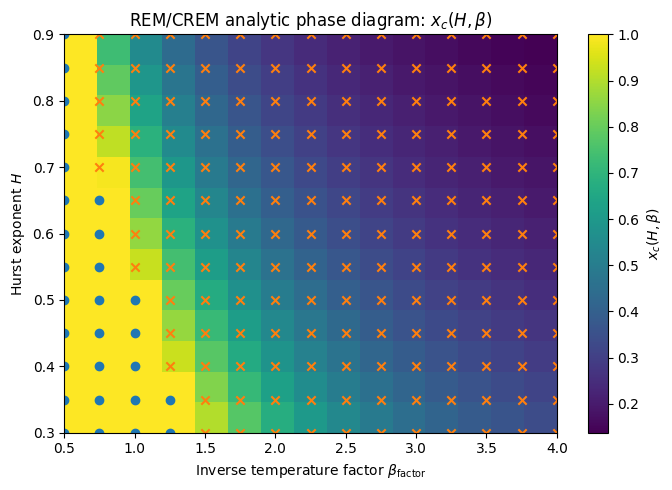

In [5]:
def plot_phase_diagram_REM(phase_result):
    H_values = phase_result["H_values"]
    beta_factors = phase_result["beta_factors"]
    x_grid = phase_result["x_grid"]
    rs_mask = phase_result["rs_mask"]
    rsb_mask = phase_result["rsb_mask"]

    plt.figure(figsize=(7, 5))
    plt.imshow(
        x_grid,
        origin="lower",
        extent=(beta_factors.min(), beta_factors.max(),
                H_values.min(), H_values.max()),
        aspect="auto"
    )
    plt.colorbar(label=r"$x_c(H,\beta)$")

    # Overlay RS (blue dots) and RSB (crosses)
    rs_points = np.where(rs_mask)
    if rs_points[0].size > 0:
        plt.scatter(beta_factors[rs_points[1]],
                    H_values[rs_points[0]])

    rsb_points = np.where(rsb_mask)
    if rsb_points[0].size > 0:
        plt.scatter(beta_factors[rsb_points[1]],
                    H_values[rsb_points[0]],
                    marker="x")

    plt.xlabel(r"Inverse temperature factor $\beta_{\mathrm{factor}}$")
    plt.ylabel(r"Hurst exponent $H$")
    plt.title(r"REM/CREM analytic phase diagram: $x_c(H,\beta)$")
    plt.tight_layout()
    plt.show()


plot_phase_diagram_REM(phase_rem)

## 6. How this matches the paper

This REM/CREM-style phase diagram is **consistent with the theoretical
narrative in the paper**, under an additional simplification:

- Section 4.4 argues that the breakpoint $x_c(\beta,H)$ is determined
  by a 1-RSB variational principle, and that the dependence on the
  fractal input enters only through the spectrum $\rho_C(\lambda;H)$.
- In the REM/CREM limit, this variational problem reduces to a
  closed-form relation
  $$x_c(\beta,H) = \min\!\left(1,\; \beta_c(H)/\beta\right),$$
  where $\beta_c(H)$ is an $H$-dependent critical inverse temperature
  set by the disorder variance (here encoded by $J_{\mathrm{eff}}(H)$).

Therefore this notebook can be cited as implementing a **simplified
correlated REM approximation** to the more general 1-RSB framework
described in the main text.  The qualitative dependence of the critical
manifold on $H$ (through the spectrum) is preserved, while yielding a
transparent analytic expression for $x_c(H,\beta)$.